**Setup and Installations**


In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from google.colab import drive
from huggingface_hub import notebook_login
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

RNG = 42

# --- MOUNTING GOOGLE DRIVE & LOGGING IN ---
drive.mount('/content/drive')
notebook_login()

# --- LOADING THE DATASET ---
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'
df = pd.read_csv(FILE_PATH)

# quick sanity
needed_cols = [
    'title','reviewText','sentiment_label','tomatoMeter','genre',
    'audienceScore','runtimeMinutes','language_encoded','director_encoded'
]
missing = [c for c in needed_cols if c not in df.columns]
assert not missing, f"Missing columns in CSV: {missing}"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.2 MB/s eta 0:00:00
Mounted at /content/drive


** Feature Preprocessing**

In [5]:
# --- CLEAN MINIMUMS ---
df = df.dropna(subset=['reviewText', 'sentiment_label']).copy()
df['label'] = df['sentiment_label'].astype(int)

# Class names for binary report
class_names = ['Negative', 'Positive']

# Text fields
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

# --- STRATIFIED SPLIT ---
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)
y_test  = test_df['label'].values.astype(int)

# ============ FIT PREPROCESSORS ON TRAIN ONLY ============

# --- Numeric: fill NA with train medians, then scale ---
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)   # fit on train only

# --- Categorical: genre (multi-label) ---
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# --- language_encoded: One-Hot (small cardinality) ---
# (version-safe: sklearn ≥1.2 uses 'sparse_output' instead of 'sparse')
import sklearn
from packaging import version

train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())


# --- director_encoded: Frequency + K-fold target mean (leak-safe) ---
def director_features(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, n_splits: int = 5):
    """Leak-safe target encoding with a frequency feature."""
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency (log1p) using TRAIN counts only
    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32)

    # K-fold target mean with global prior (leak-safe)
    global_mean = y.mean()
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    tr_te = np.zeros(len(s_train), dtype=np.float32)

    for tr_i, val_i in skf.split(np.zeros(len(y)), y):
        tr_part = s_train.iloc[tr_i]
        y_part  = y[tr_i]
        # mean per director on fold-train
        means = tr_part.groupby(tr_part).apply(
            lambda idx: y_part[tr_part.index == idx.name].mean()
        )
        tr_te[val_i] = s_train.iloc[val_i].map(means).fillna(global_mean).astype(np.float32).values

    # Test target mean: compute means on FULL train, then map
    full_means = s_train.groupby(s_train).apply(
        lambda idx: y[s_train.index == idx.name].mean()
    )
    te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]

    return tr_freq, te_freq, tr_te[:, None], te_te

# choose column: if you had raw 'director', use it; else use encoded
if 'director' in train_df.columns:
    dtr_f, dte_f, dtr_te, dte_te = director_features(train_df['director'], y_train, test_df['director'])
else:
    dtr_f, dte_f, dtr_te, dte_te = director_features(
        train_df['director_encoded'].astype(str), y_train,
        test_df['director_encoded'].astype(str)
    )

# Final director block = [freq, target_mean]
dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)  # shape (N, 2)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)  # shape (M, 2)


/tmp/ipython-input-2893759880.py:77: RuntimeWarning: Mean of empty slice.
  lambda idx: y_part[tr_part.index == idx.name].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2893759880.py:77: RuntimeWarning: Mean of empty slice.
  lambda idx: y_part[tr_part.index == idx.name].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2893759880.py:77: RuntimeWarning: Mean of empty slice.
  lambda idx: y_part[tr_part.index == idx.name].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2893759880.py:77: RuntimeWarning: Mean of empty slice.
  lambda idx: y_part[tr_part.index == idx.na

**Dataset Preparation and Tokenization**

In [6]:
def build_features(split_df: pd.DataFrame, dir_block: np.ndarray):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # numeric → fill with TRAIN medians, then TRAIN scaler
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    numeric_scaled = scaler.transform(numeric.values).astype(np.float32)   # (N, 3)
    out['numerical_features'] = [row for row in numeric_scaled]

    # genre multi-hot via TRAIN-fitted mlb
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    genre_bin = mlb.transform(genre_list).astype(np.float32)               # (N, G)

    # language one-hot via TRAIN-fitted OHE
    lang = split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
    lang_ohe = ohe_lang.transform(lang.to_frame()).astype(np.float32)      # (N, L)

    # director (provided precomputed leak-safe block: (N, 2))
    cat = np.concatenate([genre_bin, lang_ohe, dir_block], axis=1).astype(np.float32)
    out['categorical_features'] = [row for row in cat]
    return out

train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df,  dir_test_block)

# sizes for the classifier head
num_numerical_features = 3
num_genre = len(mlb.classes_)
num_lang  = ohe_lang.get_feature_names_out().shape[0]
num_dir_enc = 2  # frequency + target mean
num_categorical_features = num_genre + num_lang + num_dir_enc

print("Dims — numeric:", num_numerical_features,
      "| genre:", num_genre, "| lang:", num_lang,
      "| director_block:", num_dir_enc, "| categorical total:", num_categorical_features)

# --- Wrap into DataFrames for HF ---
final_train_df = pd.DataFrame({
    'combined_text': train_feats['combined_text'],
    'label': train_feats['label'],
    'numerical_features': train_feats['numerical_features'],
    'categorical_features': train_feats['categorical_features'],
})
final_test_df = pd.DataFrame({
    'combined_text': test_feats['combined_text'],
    'label': test_feats['label'],
    'numerical_features': test_feats['numerical_features'],
    'categorical_features': test_feats['categorical_features'],
})

# --- HF Dataset ---
raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(final_train_df),
    'test':  Dataset.from_pandas(final_test_df),
})

# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_multimodal_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)

cols_to_remove = [c for c in ["combined_text", "__index_level_0__"] if c in tokenized_multimodal_datasets["train"].column_names]
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(cols_to_remove)
tokenized_multimodal_datasets.set_format("torch")


Dims — numeric: 3 | genre: 32 | lang: 14 | director_block: 2 | categorical total: 48


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

**Training the Binary Model**

In [7]:
# --- MODEL ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features):
        super(MultimodalClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]  # (B, H)
        pooled_output = self.dropout(cls_token_output)

        # numerical_features: (B, 3); categorical_features: (B, K)
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        numerical_features = np.stack([np.array(f['numerical_features'], dtype=np.float32) for f in features])
        categorical_features = np.stack([np.array(f['categorical_features'], dtype=np.float32) for f in features])
        batch['labels'] = torch.tensor([int(f['label']) for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.tensor(numerical_features, dtype=torch.float32)
        batch['categorical_features'] = torch.tensor(categorical_features, dtype=torch.float32)
        return batch

# --- INIT MODEL & COLLATOR ---
multimodal_model = MultimodalClassifier(
    num_labels=2,
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features
)
data_collator = MultimodalDataCollator(tokenizer)

# --- METRICS ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# --- TRAINING ARGS ---
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_binary_multimodal_ALL_FEATURES_DIRTE",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50
)

# --- TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- TRAIN ---
print("\n--- Starting Training for Multimodal Binary Model (ALL FEATURES + Director TargetEnc) ---")
multimodal_trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


--- Starting Training for Multimodal Binary Model (ALL FEATURES + Director TargetEnc) ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rafid2542 (rafid2542-ahsanullah-university-of-science-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.277900,0.299409,0.876081,0.873134,0.897908,0.849691
2,0.254200,0.298803,0.886502,0.887349,0.884016,0.890707
3,0.148100,0.397589,0.884089,0.884537,0.884401,0.884672


TrainOutput(global_step=29220, training_loss=0.23820556938281048, metrics={'train_runtime': 10414.9756, 'train_samples_per_second': 44.889, 'train_steps_per_second': 2.806, 'total_flos': 0.0, 'train_loss': 0.23820556938281048, 'epoch': 3.0})

**Enhanced Evaluation for  Binary Model**

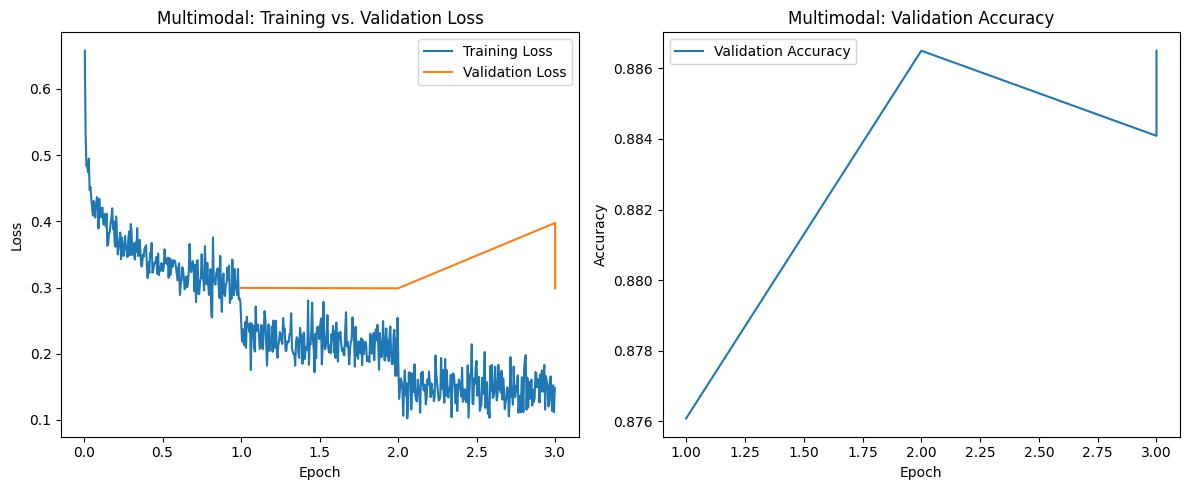


--- Final Evaluation on Test Set (Multimodal, ALL FEATURES + Director TargetEnc) ---


{'eval_loss': 0.29880282282829285, 'eval_accuracy': 0.8865018865018865, 'eval_f1': 0.8873490599684108, 'eval_precision': 0.8840160397949343, 'eval_recall': 0.890707308341431, 'eval_runtime': 260.4801, 'eval_samples_per_second': 149.574, 'eval_steps_per_second': 9.352, 'epoch': 3.0}
Logits shape: (38961, 2)

--- Classification Report (Multimodal, ALL FEATURES + Director TargetEnc) ---
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     19408
    Positive       0.88      0.89      0.89     19553

    accuracy                           0.89     38961
   macro avg       0.89      0.89      0.89     38961
weighted avg       0.89      0.89      0.89     38961



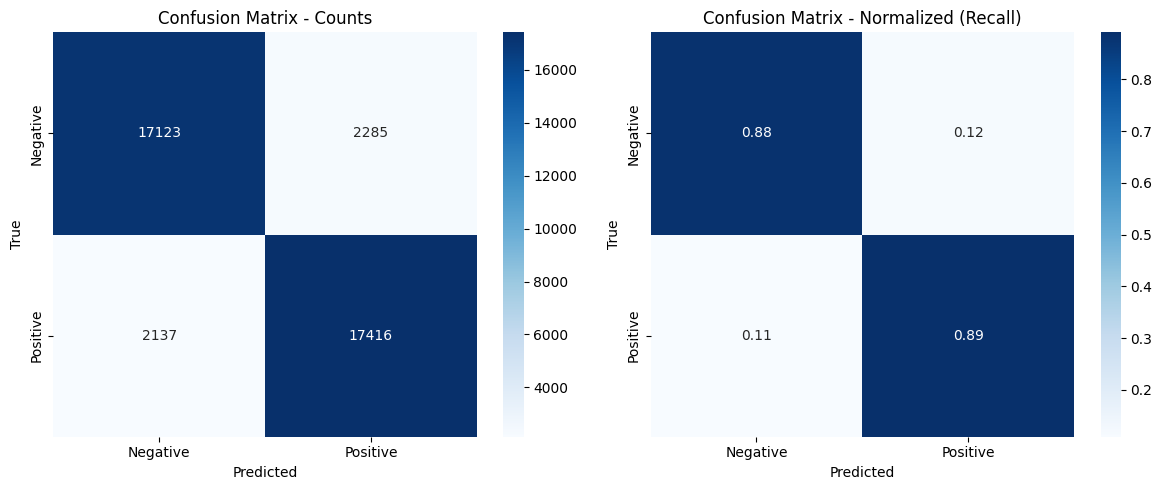

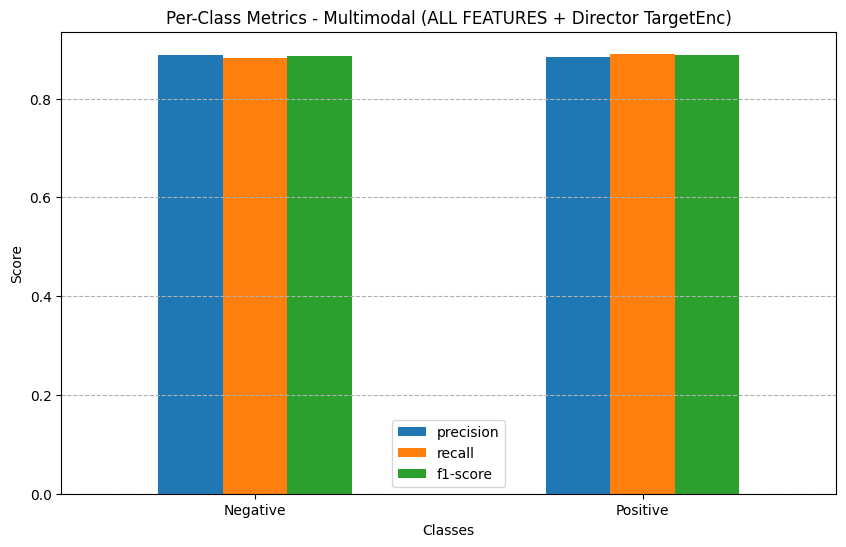


Multimodal model saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_multimodal_ALL_FEATURES_DIRTE
First 10 preds vs true: [(np.int64(1), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(1), np.int64(1)), (np.int64(1), np.int64(1)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(1))]


In [9]:
# ==========================
# EVALUATE • REPORT • PLOTS • SAVE (Multimodal)
# ==========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

try:
    class_names
except NameError:
    num_labels = getattr(multimodal_trainer.model.config, "num_labels", None)
    if num_labels is None:
        uniq = sorted(set(tokenized_multimodal_datasets["test"]["label"]))
        num_labels = len(uniq)
    class_names = [f"Class {i}" for i in range(num_labels)]
    print(f"[Info] 'class_names' not found; using defaults: {class_names}")

# --- Curves ---
log_history = multimodal_trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
         [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
         [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Multimodal: Training vs. Validation Loss'); plt.legend()

plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
             [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Multimodal: Validation Accuracy'); plt.legend()
else:
    plt.text(0.5, 0.5, 'No eval accuracy logged', ha='center', va='center')
    plt.axis('off')
plt.tight_layout(); plt.show()

# --- Final Eval ---
print("\n--- Final Evaluation on Test Set (Multimodal, ALL FEATURES + Director TargetEnc) ---")
multimodal_eval_results = multimodal_trainer.evaluate()
print(multimodal_eval_results)

pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])
logits = pred_out.predictions[0] if isinstance(pred_out.predictions, (list, tuple)) else pred_out.predictions
logits = np.asarray(logits)
print("Logits shape:", logits.shape)

# logits -> labels
if logits.ndim == 2:
    multimodal_predicted_labels = np.argmax(logits, axis=-1)
    num_classes = logits.shape[1]
elif logits.ndim == 1:
    multimodal_predicted_labels = (logits > 0).astype(int)
    num_classes = 2
else:
    raise ValueError(f"Unexpected logits ndim: {logits.ndim}")

if len(class_names) != num_classes:
    print(f"[Warn] Adjusting class_names from {len(class_names)} to {num_classes}.")
    class_names = [f"Class {i}" for i in range(num_classes)]

true_labels = np.asarray(tokenized_multimodal_datasets["test"]["label"]).astype(int)

# --- Report ---
print("\n--- Classification Report (Multimodal, ALL FEATURES + Director TargetEnc) ---")
report_text = classification_report(true_labels, multimodal_predicted_labels,
                                    target_names=class_names, zero_division=0)
print(report_text)

report = classification_report(true_labels, multimodal_predicted_labels,
                               target_names=class_names, output_dict=True, zero_division=0)

# --- Confusion Matrices ---
cm = confusion_matrix(true_labels, multimodal_predicted_labels, labels=list(range(num_classes)))
row_sums = cm.sum(axis=1, keepdims=True); row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Counts')

plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix - Normalized (Recall)')
plt.tight_layout(); plt.show()

# --- Per-class bar chart ---
report_df = pd.DataFrame(report).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics - Multimodal (ALL FEATURES + Director TargetEnc)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend()
plt.show()

# --- SAVE MODEL ---
output_multimodal_model_path = "/content/drive/MyDrive/THESIS 47/Saved Datasets/[Binary]fine-tuned_multimodal_ALL_FEATURES_DIRTE"
multimodal_trainer.save_model(output_multimodal_model_path)
print(f"\nMultimodal model saved to: {output_multimodal_model_path}")

# --- QUICK PEEK ---
print("First 10 preds vs true:",
      list(zip(multimodal_predicted_labels[:10], true_labels[:10])))